In [1]:
import os
import json
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px
import matplotlib.pyplot as plt
from collections import defaultdict
from upsetplot import UpSet, from_indicators


In [2]:
sid = "2025-08-12-14-22-26"


In [3]:
with open(f"../data/merged/{sid}.json", "r") as f:
    data = json.load(f)

d = {"Signin": 0, "MFA": 0, "Both": 0}
for e in data:
    if e["signin"] is True and e["mfa"] is True:
        d["Both"] += 1
    elif e["signin"] is True:
        d["Signin"] += 1
    elif e["mfa"] is True:
        d["MFA"] += 1

df = pd.DataFrame(list(d.items()), columns=["Method", "Websites"])

fig = px.pie(df, values="Websites", names="Method", template="presentation")
fig.update_traces(textposition="inside", textinfo="percent+label", textfont=dict(size=50))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), width=500, height=700, showlegend=False)

fig.show()
fig.write_image(f"./charts/{sid}_methods.pdf")


In [4]:
with open(f"../data/merged/{sid}.json", "r") as f:
    data = json.load(f)

d = {}
for e in data:
    for dir in e["directories"]:
        d[dir] = d.get(dir, 0) + 1

d = {k.replace("passkeys-directory.dashlane.com", "dashlane.com"): v for k, v in d.items()}

df = pd.DataFrame(list(d.items()), columns=["Directories", "Websites"])
df = df.sort_values(by="Websites", ascending=False)

fig = px.bar(df, x="Directories", y="Websites", text="Directories", template="presentation")
fig.update_traces(textposition="inside", textfont=dict(size=24))
fig.update_layout(margin=dict(l=80, r=10, t=0, b=40), width=700, height=500)
fig.update_xaxes(showticklabels=False)

fig.show()
fig.write_image(f"./charts/{sid}_directories.pdf")


In [5]:
with open(f"../data/merged/{sid}.json") as f:
    data = json.load(f)

d = {(e["domain"] or e["name"]): len(e["directories"]) + len(e["wellknown"]) for e in data}

df = pd.DataFrame(d.items(), columns=["Websites", "Sources"])
df = df[df["Sources"] >= 8].sort_values("Sources", ascending=False)

fig = px.bar(df, x="Websites", y="Sources")
fig.show()


In [6]:
with open(f"../data/merged/{sid}.json") as f:
    data = json.load(f)

dir_coverage = defaultdict(set)
website_count = len(data)

for e in data:
    for dir in e["directories"]:
        dir_coverage[dir].add(e["domain"] or e["name"])

dir_percentages = {source: len(websites) / website_count * 100 for source, websites in dir_coverage.items()}
sorted_dirs = sorted(dir_percentages.items(), key=lambda x: x[1], reverse=True)

total_covered = 0
selected_dirs = []
covered_websites = set()

for dir, coverage in sorted_dirs:
    selected_dirs.append(dir)
    covered_websites.update(dir_coverage[dir])
    total_covered = len(covered_websites) / website_count * 100
    if total_covered >= 95:
        break

print(f"# Directories to cover at least 95% of the websites: {len(selected_dirs)}")
print(f"Directories to cover at least 95% of the websites: {selected_dirs}")


# Directories to cover at least 95% of the websites: 12
Directories to cover at least 95% of the websites: ['passkeys.directory', 'hideez.com', 'keepersecurity.com', 'passkeys.2stable.com', 'passkeys.2fa.directory', 'passkeys.com', '2fa.directory', 'fidoalliance.org', 'passkeys-directory.dashlane.com', 'passkeyindex.io', 'enpass.io', 'passkeys.io']


/Users/louis/.local/share/virtualenvs/notebooks-v7r8_WzV/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/louis/.local/share/virtualenvs/notebooks-v7r8_WzV/lib/python3.13/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

<Figure size 500x500 with 0 Axes>

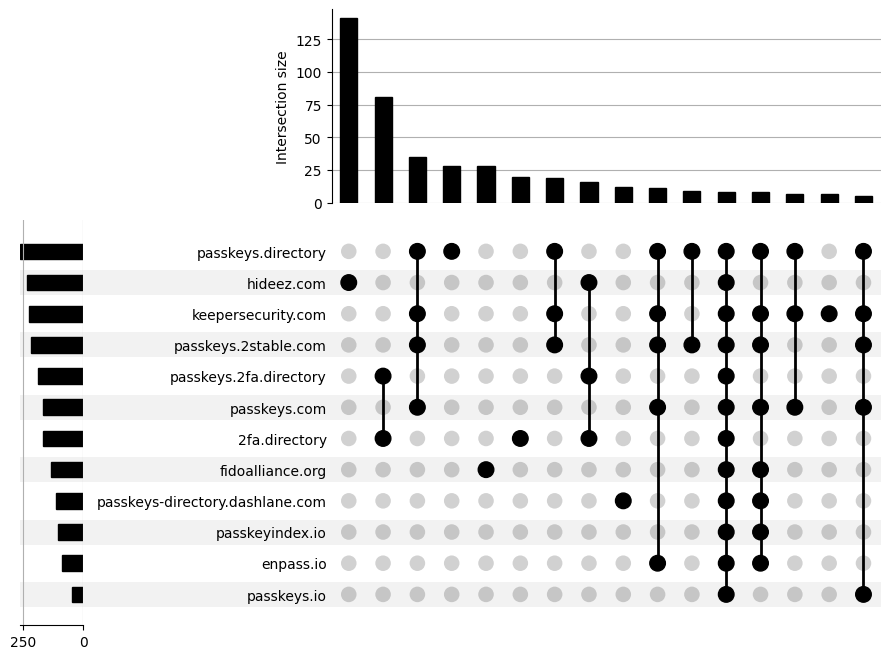

In [7]:
with open(f"../data/merged/{sid}.json") as f:
    data = json.load(f)

d = []
dirs = set()
for e in data:
    if not e["directories"]:
        continue
    s = e["directories"].keys()
    dirs.update(s)
    d.append({"website": e.get("domain") or e.get("name"), **{k: 1 for k in s}})

df = pd.DataFrame(d)
df = df.fillna(False)
df = df.set_index("website")
df = df.astype(bool)

upset = from_indicators(list(dirs), df)

plt.figure(figsize=(5, 5))
UpSet(upset, sort_by="cardinality", sort_categories_by="-cardinality", min_subset_size=5).plot()

plt.savefig(f"./charts/{sid}_upset.pdf", bbox_inches="tight")
plt.show()


In [8]:
d = []

day_values = {}
for file in sorted(os.listdir("../data/merged")):
    if not file.endswith(".json"):
        continue
    id = file.split(".")[0]
    dt = datetime.strptime(id, "%Y-%m-%d-%H-%M-%S")
    with open(f"../data/merged/{id}.json") as f:
        j = json.load(f)
        day_values[dt.date()] = len(j)

current_day = min(day_values)
end_day = max(day_values)
last_val = None

while current_day <= end_day:
    if current_day in day_values:
        last_val = day_values[current_day]
    if last_val is not None:
        d.append({"time": current_day.strftime("%Y-%m-%d"), "sites": last_val})
    current_day += timedelta(days=1)

df = pd.DataFrame(d)

fig = px.line(df, x="time", y="sites", line_shape="spline")

fig.update_traces(line_smoothing=0, line_width=3)
fig.update_layout(margin=dict(l=100, r=0, t=0, b=0), width=1000, height=500)
fig.update_xaxes(showticklabels=True, title_text="Time", title_font=dict(size=24), tickfont=dict(size=18))
fig.update_yaxes(showticklabels=True, title_text="# Websites", title_font=dict(size=24), tickfont=dict(size=18))

fig.show()
fig.write_image(f"./charts/{sid}_sites_by_time.pdf")


In [26]:
import os
import json
import datetime
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Set the path to your main data directory here
data_dir = "../data/directories"

# Prepare a list to hold data from all subdirectories (types)
all_subdir_dfs = []

# 1) Traverse each subdirectory (type) in data_dir
for sub_name in os.listdir(data_dir):
    sub_path = os.path.join(data_dir, sub_name)

    if sub_name == "passkeys-directory.dashlane.com":
        sub_name = "dashlane.com"

    if not os.path.isdir(sub_path):
        # Skip if it's not a directory
        continue

    # SPECIAL CASE for passkeys.directory, enpass.io, fidoalliance.org
    # ----------------------------------------------------------------
    # Same logic:
    #   - Only read the single most recent file in that directory
    #   - Each file is a JSON list of items
    #   - Each item has a creation field:
    #       * passkeys.directory: "created_at" (ISO8601)
    #       * enpass.io:         "created_date" (epoch string)
    #       * fidoalliance.org:  "post_date" (epoch string)
    #   - For each item, parse its creation date into a day
    #   - We compute daily *cumulative* totals
    #     (once an item is created, it remains in subsequent days)
    if sub_name in ("passkeys.directory", "enpass.io", "fidoalliance.org"):
        most_recent_file = None
        most_recent_ts = None

        # Find the most recent file based on timestamp in filename
        for filename in os.listdir(sub_path):
            if not filename.endswith(".json"):
                continue

            base_name = filename[:-5]  # remove ".json"

            # Expected format: YYYY-MM-DD-HH-MM-SS.json
            try:
                ts = datetime.datetime.strptime(base_name, "%Y-%m-%d-%H-%M-%S")
            except ValueError:
                continue

            if most_recent_ts is None or ts > most_recent_ts:
                most_recent_ts = ts
                most_recent_file = filename

        # If there's a valid most recent file, process it
        if most_recent_file:
            file_path = os.path.join(sub_path, most_recent_file)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data_array = json.load(f)  # Expecting a list of dicts
            except (json.JSONDecodeError, FileNotFoundError):
                # Skip if there's an issue reading the file
                continue

            # We'll collect the creation dates here (as datetime.date objects)
            creation_dates = []

            for item in data_array:
                if sub_name == "passkeys.directory":
                    if not (item["passkey_signin"] or item["passkey_mfa"]):
                        continue
                    # The creation field is "created_at" (ISO 8601)
                    created_str = item.get("created_at")
                    if not created_str:
                        continue
                    # Convert any trailing "Z" to "+00:00"
                    created_str = created_str.replace("Z", "+00:00")
                    try:
                        created_dt = datetime.datetime.fromisoformat(created_str)
                        creation_dates.append(created_dt.date())
                    except ValueError:
                        continue

                elif sub_name == "enpass.io":
                    # The creation field is "created_date" (epoch time as string)
                    created_str = item.get("created_date")
                    if not created_str:
                        continue
                    try:
                        epoch_val = int(created_str)
                        # Convert to UTC datetime, then just keep the date
                        created_dt = datetime.datetime.utcfromtimestamp(epoch_val)
                        creation_dates.append(created_dt.date())
                    except ValueError:
                        continue

                else:  # sub_name == "fidoalliance.org"
                    # The creation field is "post_date" (epoch time as string)
                    created_str = item.get("post_date")
                    if not created_str:
                        continue
                    try:
                        epoch_val = int(created_str)
                        created_dt = datetime.datetime.utcfromtimestamp(epoch_val)
                        creation_dates.append(created_dt.date())
                    except ValueError:
                        continue

            # At this point, creation_dates holds the day each item was created
            if creation_dates:
                # Group by the creation day and count how many items were created on each day
                creation_series = pd.Series(creation_dates)
                daily_counts = creation_series.value_counts().sort_index()

                # Turn this into a DataFrame: date -> how many items were created that day
                df_special = pd.DataFrame({
                    "date": daily_counts.index,
                    "daily_new": daily_counts.values
                }).sort_values("date")

                # Compute cumulative total to reflect "once created, item stays forever"
                df_special["count"] = df_special["daily_new"].cumsum()

                # We only keep the "date" and "count" columns
                df_special = df_special[["date", "count"]]

                # Add the "type" column
                df_special["type"] = sub_name

                all_subdir_dfs.append(df_special)

        # Done processing for passkeys.directory / enpass.io / fidoalliance.org
        continue

    # NORMAL CASE for other subdirectories:
    # -------------------------------------
    # - We track the earliest JSON file per day (lowest hour).
    # - Then we use that file's JSON array length as the count.
    daily_data = {}

    # Go through JSON files in this subdirectory
    for filename in os.listdir(sub_path):
        if not filename.endswith(".json"):
            continue

        base_name = filename[:-5]  # remove ".json"

        # Expected format: YYYY-MM-DD-HH-MM-SS.json
        try:
            ts = datetime.datetime.strptime(base_name, "%Y-%m-%d-%H-%M-%S")
        except ValueError:
            # If the filename doesn't match the expected format, skip
            continue

        file_path = os.path.join(sub_path, filename)

        # Read the JSON array and count its length
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data_array = json.load(f)
        except (json.JSONDecodeError, FileNotFoundError):
            # Skip if there's an issue reading the file
            continue

        if sub_name == "2fa.directory":
            count_items = len([c for c in data_array if "tfa" in c and "u2f" in c["tfa"]])
        else:
            count_items = len(data_array)

        if count_items < 5:
            continue

        day = ts.date()  # We'll group by day

        # If this is the first time we see this day, or if we've found an earlier timestamp
        if day not in daily_data:
            daily_data[day] = (ts, count_items)
        else:
            existing_ts, existing_count = daily_data[day]
            if ts < existing_ts:
                daily_data[day] = (ts, count_items)

    # Sort days and build a DataFrame: date -> count
    sorted_days = sorted(daily_data.keys())
    if not sorted_days:
        # If there's no valid data for this subdirectory, skip
        continue

    subdir_df = pd.DataFrame({
        "date": sorted_days,
        "count": [daily_data[d][1] for d in sorted_days],
        "type": sub_name
    })

    all_subdir_dfs.append(subdir_df)

# Process well-known endpoints data
wellknown_endpoints_path = "../data/wellknown/endpoints"
wellknown_webauthn_path = "../data/wellknown/webauthn"

for wellknown_path, wellknown_name in [(wellknown_endpoints_path, "well-known/endpoints"),
                                         (wellknown_webauthn_path, "well-known/webauthn")]:
    if os.path.isdir(wellknown_path):
        daily_data = {}

        for filename in os.listdir(wellknown_path):
            if not filename.endswith(".json"):
                continue

            base_name = filename[:-5]  # remove ".json"

            try:
                ts = datetime.datetime.strptime(base_name, "%Y-%m-%d-%H-%M-%S")
            except ValueError:
                continue

            file_path = os.path.join(wellknown_path, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data_array = json.load(f)
            except (json.JSONDecodeError, FileNotFoundError):
                continue

            count_items = len(data_array)

            if count_items < 5:
                continue

            day = ts.date()

            if day not in daily_data:
                daily_data[day] = (ts, count_items)
            else:
                existing_ts, existing_count = daily_data[day]
                if ts < existing_ts:
                    daily_data[day] = (ts, count_items)

        sorted_days = sorted(daily_data.keys())
        if sorted_days:
            wellknown_df = pd.DataFrame({
                "date": sorted_days,
                "count": [daily_data[d][1] for d in sorted_days],
                "type": wellknown_name
            })
            all_subdir_dfs.append(wellknown_df)

# Add merged directory data with filtering for drops > 100
merged_files_data = []
for file in sorted(os.listdir("../data/merged")):
    if not file.endswith(".json"):
        continue
    id = file.split(".")[0]
    dt = datetime.datetime.strptime(id, "%Y-%m-%d-%H-%M-%S")
    with open(f"../data/merged/{id}.json") as f:
        j = json.load(f)
        merged_files_data.append((dt, len(j)))

# Sort by datetime
merged_files_data.sort(key=lambda x: x[0])

# Filter out files with large drops, but keep actual values when they're acceptable
filtered_merged_data = []
last_good_count = 0

for dt, count in merged_files_data:
    # Skip this data point if it drops more than 100 from the last good value
    if count < last_good_count - 100:
        continue  # Skip this data point entirely
    else:
        # This is a good data point, keep it with its actual value
        filtered_merged_data.append((dt, count))
        last_good_count = count

# Convert filtered data to day-based dictionary
merged_day_values = {}
for dt, count in filtered_merged_data:
    merged_day_values[dt.date()] = count

if merged_day_values:
    merged_dates = []
    merged_counts = []

    current_day = min(merged_day_values)
    end_day = max(merged_day_values)
    last_val = None

    while current_day <= end_day:
        if current_day in merged_day_values:
            last_val = merged_day_values[current_day]
        if last_val is not None:
            merged_dates.append(current_day)
            merged_counts.append(last_val)
        current_day += datetime.timedelta(days=1)

    merged_df = pd.DataFrame({
        "date": merged_dates,
        "count": merged_counts,
        "type": "merged"
    })
    all_subdir_dfs.append(merged_df)

# If no data was collected at all, just stop
if not all_subdir_dfs:
    print("No valid JSON files found.")
else:
    # 2) Combine data from all subdirectories
    combined_df = pd.concat(all_subdir_dfs, ignore_index=True)

    # Get global min and max dates
    min_date = combined_df["date"].min()
    max_date = combined_df["date"].max()

    # Build a daily date range
    all_dates = pd.date_range(start=min_date, end=max_date, freq="D")

    # 3) For each type, forward-fill missing days
    reindexed_frames = []
    for t in combined_df["type"].unique():
        df_t = combined_df[combined_df["type"] == t].copy()
        df_t.set_index("date", inplace=True)
        df_t = df_t.sort_index()

        # Reindex on the full daily range
        df_t = df_t.reindex(all_dates, method=None)  # days without data become NaN

        # Forward fill the counts
        df_t["count"] = df_t["count"].ffill()

        # Fill in the type column
        df_t["type"] = df_t["type"].fillna(t)

        # Reset the index
        df_t = df_t.reset_index().rename(columns={"index": "date"})
        reindexed_frames.append(df_t)

    final_df = pd.concat(reindexed_frames, ignore_index=True)

    # Transform counts for mixed linear/log scale
    # Below 400: linear, above 400: logarithmic
    def transform_count(y):
        if pd.isna(y):
            return y
        threshold = 400
        if y <= threshold:
            return y
        else:
            # Logarithmic scaling above 400
            # We'll use log base 10 and scale it so it connects smoothly at 400
            log_base = 10
            log_offset = threshold - threshold * np.log10(threshold) / np.log10(final_df["count"].max())
            return threshold + (np.log10(y) - np.log10(threshold)) * 200

    final_df["transformed_count"] = final_df["count"].apply(transform_count)

    # 4) Create the line chart with Plotly Graph Objects for custom y-axis
    fig = go.Figure()

    # Get color palette
    colors = px.colors.qualitative.Bold
    color_map = {}
    for i, t in enumerate(final_df["type"].unique()):
        color_map[t] = colors[i % len(colors)]

    # Add traces for each type
    for t in final_df["type"].unique():
        df_t = final_df[final_df["type"] == t]

        line_style = {}
        if t in ["well-known/endpoints", "well-known/webauthn"]:
            line_style = dict(dash="dot", width=3, color=color_map[t])
        elif t == "merged":
            line_style = dict(dash="dash", width=3, color="black")
        else:
            line_style = dict(width=1.5, color=color_map[t])

        fig.add_trace(go.Scatter(
            x=df_t["date"],
            y=df_t["transformed_count"],
            mode="lines",
            name=t,
            line=line_style,
            customdata=df_t["count"],
            hovertemplate="<b>%{fullData.name}</b><br>Date: %{x}<br>Count: %{customdata}<extra></extra>"
        ))

    # Custom y-axis with break at 400
    y_ticks = [0, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000]
    y_tick_vals = [transform_count(y) for y in y_ticks]
    y_tick_text = [str(y) for y in y_ticks]

    fig.update_layout(
        showlegend=False,
        margin=dict(l=100, r=0, t=0, b=0),
        width=1500,
        height=600,
        yaxis=dict(
            tickmode="array",
            tickvals=y_tick_vals,
            ticktext=y_tick_text,
            title_text="# Websites",
            title_font=dict(size=24),
            tickfont=dict(size=18),
            showgrid=True,
            gridcolor="lightgray"
        ),
        xaxis=dict(
            title_text="Date",
            title_font=dict(size=24),
            tickfont=dict(size=16),
            tickformat="%m/%Y"
        )
    )

    # Add annotations for line labels
    for trace in fig.data:
        x_val = trace.x[-1] + pd.Timedelta(days=5)
        y_val = trace.y[-1]

        # Adjust label positions for overlapping lines
        if trace.name == "2fa.directory":
            y_val = transform_count(trace.customdata[-1] + 5)
        elif trace.name == "passkeys.com":
            y_val = transform_count(trace.customdata[-1] - 2)
        elif trace.name == "passkeys.2stable.com":
            y_val = transform_count(trace.customdata[-1] - 5)
        elif trace.name == "keepersecurity.com":
            y_val = transform_count(trace.customdata[-1] + 5)
        elif trace.name == "passkeys.2fa.directory":
            y_val = transform_count(trace.customdata[-1] - 10)
        elif trace.name == "well-known/webauthn":
            y_val = transform_count(trace.customdata[-1] + 7)
        elif trace.name == "merged":
            trace.name = "radar.passkeys.tools"
            y_val = transform_count(trace.customdata[-1] + 50)

        fig.add_annotation(
            x=x_val,
            y=y_val,
            text=trace.name,
            showarrow=False,
            xref="x",
            yref="y",
            xanchor="left",
            yanchor="middle",
            font=dict(color=trace.line.color)
        )

    # Add visual indicator for scale change
    fig.add_shape(
        type="line",
        x0=min_date,
        x1=max_date,
        y0=400,
        y1=400,
        line=dict(color="rgba(255, 0, 0, 0.3)", width=1),
    )

    fig.add_annotation(
        x=min_date + pd.Timedelta(days=30),
        y=415,
        text="scale change (log above)",
        showarrow=False,
        font=dict(size=18, color="red"),
        xanchor="left"
    )

    # Add vertical line at February 14, 2025
    analysis_start_date = datetime.date(2025, 2, 5)
    fig.add_shape(
        type="line",
        x0=analysis_start_date,
        x1=analysis_start_date,
        y0=0,
        y1=transform_count(1000),
        line=dict(color="rgba(255, 0, 0, 0.3)", width=1),
    )

    # Add label for the vertical line
    fig.add_annotation(
        x=analysis_start_date,
        y=0,
        text="→ start of our scans",
        showarrow=False,
        font=dict(size=18, color="red"),
        xanchor="left",
        yanchor="top",
        textangle=0
    )

    # Add label for the vertical line
    fig.add_annotation(
        x=analysis_start_date,
        y=0,
        text="archived data ←",
        showarrow=False,
        font=dict(size=18, color="red"),
        xanchor="right",
        yanchor="top",
        textangle=0
    )

    # Add increase label
    fig.add_annotation(
        x=analysis_start_date + pd.Timedelta(days=10),
        y=transform_count(600),
        text="+125%",
        showarrow=False,
        font=dict(size=18, color="red"),
        xanchor="left",
        yanchor="middle",
        textangle=0
    )

    fig.show()
    fig.write_image(f"./charts/{sid}_directories_by_time.pdf")


/var/folders/4z/4_ndqsrs5kd2_bd5mwq98xfr0000gn/T/ipykernel_74833/913693176.py:96: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/var/folders/4z/4_ndqsrs5kd2_bd5mwq98xfr0000gn/T/ipykernel_74833/913693176.py:108: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

